# Chapter 4

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import pandas as pd


ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


(1000,)


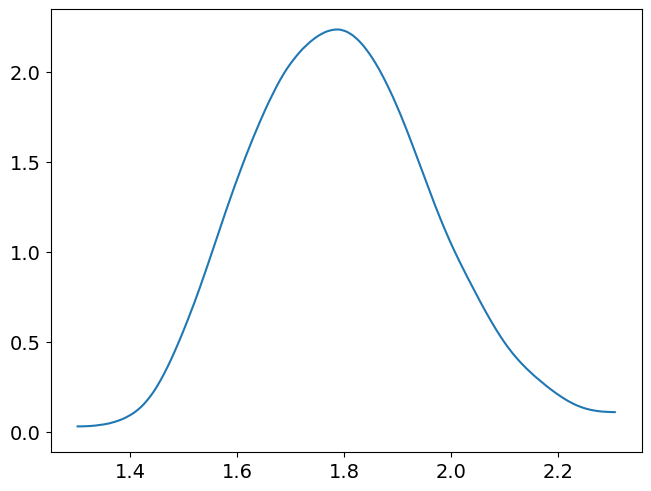

In [18]:
# code 4.2-3
s = np.zeros(1000)
for i in range(1000):
    s[i] = np.prod(np.random.uniform(1, 1.1, 12))

az.plot_kde(s)
plt.show()

(1000,)


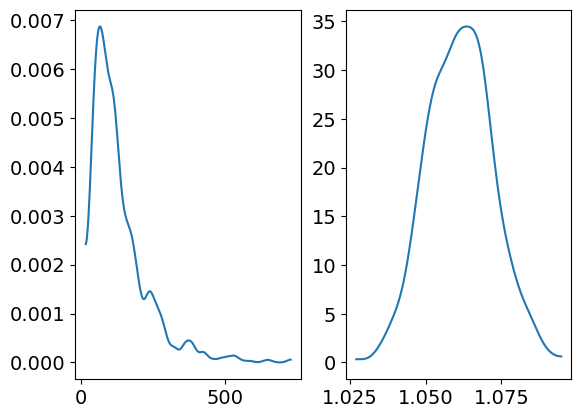

In [25]:
# code 4.4
l = np.random.uniform(1, 2, size=(12, 1000)).prod(0)
s = np.random.uniform(1, 1.01, size=(12, 1000)).prod(0)

fig, ax = plt.subplots(1,2)
az.plot_kde(l, ax=ax[0])
az.plot_kde(s, ax=ax[1])
plt.show()


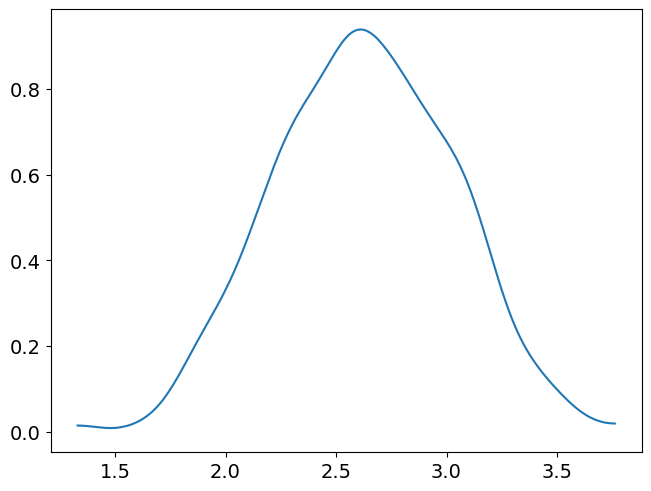

In [29]:
# code 4.5
logbig = np.log(np.random.uniform(1, 1.5, size=(12,1000)).prod(0))

az.plot_kde(logbig)
plt.show()

In [8]:
# code 4.7
d = pd.read_csv("data/Howell1.csv", sep=";", header=0)
d

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0
542,71.120,8.051258,0.0,1


In [15]:
d2 = d[d.age >= 18]
d2

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0


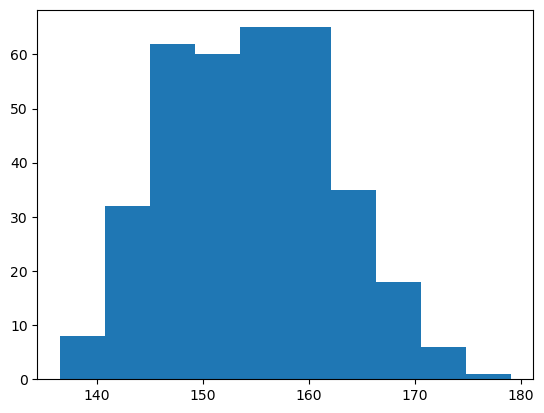

In [28]:
plt.hist(d2.height)
plt.show()

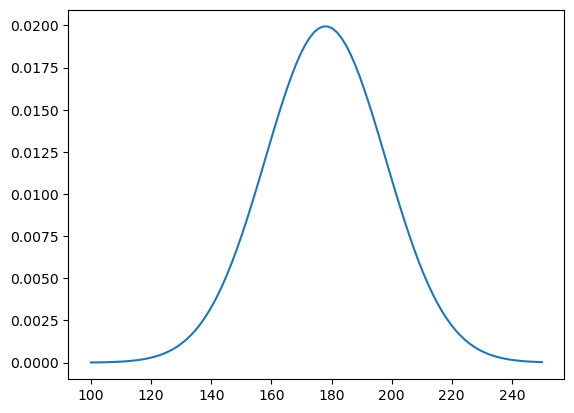

In [33]:
# code 4.12
x = np.linspace(100,250,100)
plt.plot(x, stats.norm.pdf(x, 178, 20))
plt.show()

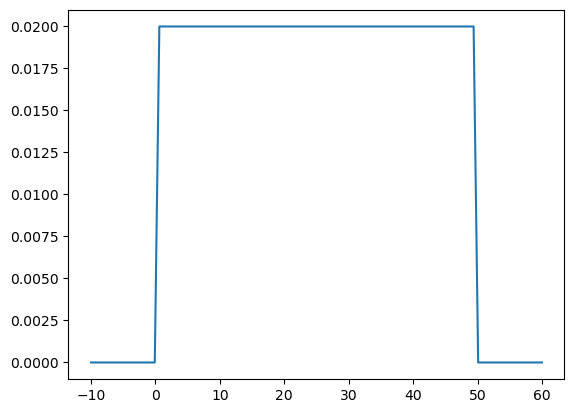

In [34]:
# code 4.13
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50))
plt.show()

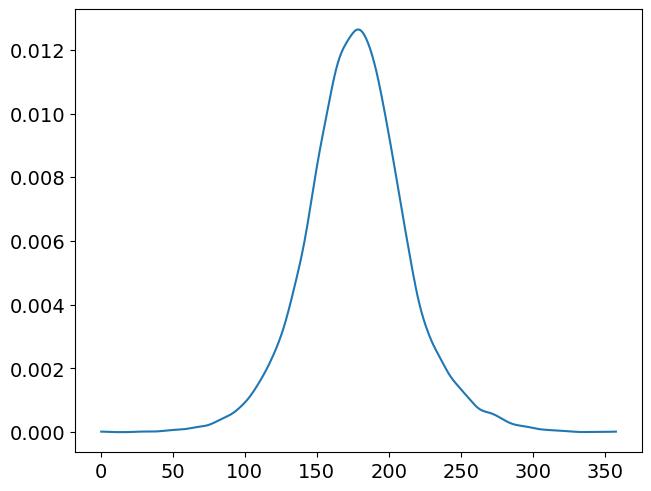

In [43]:
# code 4.14
ns = int(1e4)
sample_mu = stats.norm.rvs(loc=178, scale=20, size=ns)
sample_sigma = stats.uniform.rvs(0, 50, size=ns)
prior_h = stats.norm.rvs(sample_mu, sample_sigma, size=ns)
az.plot_kde(prior_h)
plt.show()

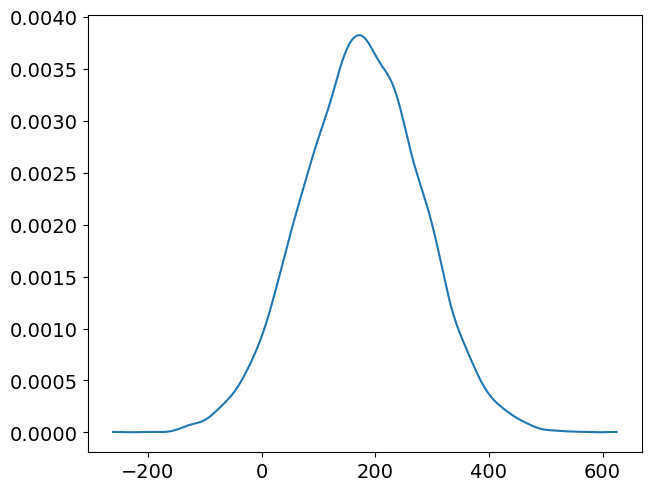

In [44]:
# code 4.15
sample_mu = stats.norm.rvs(loc=178, scale=100, size=ns)
prior_h = stats.norm.rvs(sample_mu, sample_sigma, size=ns)
az.plot_kde(prior_h)
plt.show()

In [46]:
# code 4.16
post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T

likelihood = [
    sum(stats.norm.logpdf(d2.height, loc=post[:, 0][i], scale=post[:, 1][i]))
    for i in range(len(post))
]

post_prod = (
    likelihood
    + stats.norm.logpdf(post[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post[:, 1], loc=0, scale=50)
)
post_prob = np.exp(post_prod - max(post_prod))

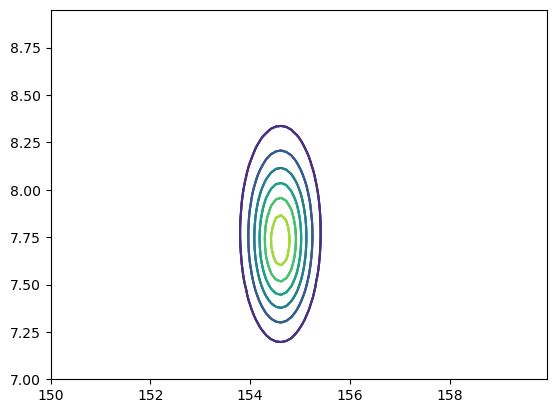

In [50]:
# code 4.17
from scipy.interpolate import griddata
xi = np.linspace(post[:, 0].min(), post[:, 0].max(), 100)
yi = np.linspace(post[:, 1].min(), post[:, 1].max(), 100)
zi = griddata((post[:, 0], post[:, 1]), post_prob, (xi[None, :], yi[:, None]))

plt.contour(xi, yi, zi);
plt.show()

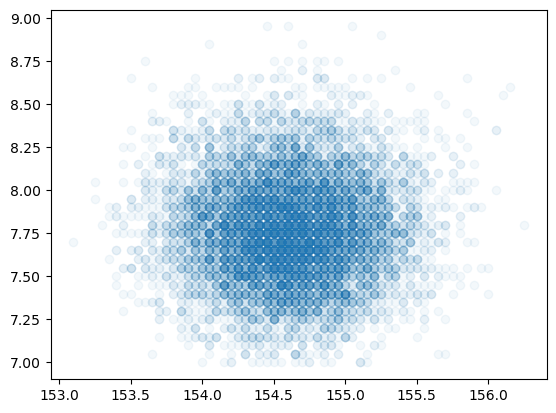

In [66]:
# code 4.19
sample_rows = np.random.choice(np.arange(len(post)), size=ns, replace=True, p=post_prob / post_prob.sum())
sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)
plt.show()

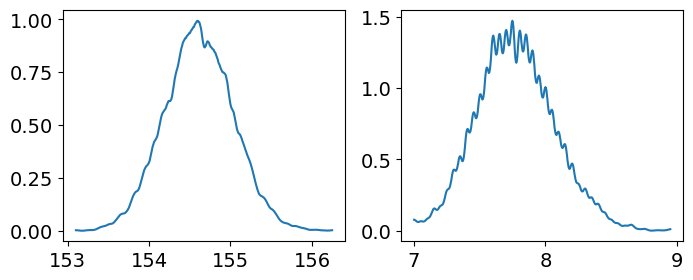

In [70]:
# code 4.21
_, ax = plt.subplots(1,2, figsize=(8,3))
az.plot_kde(sample_mu, ax=ax[0])
az.plot_kde(sample_sigma, ax=ax[1])

plt.show()

In [72]:
# code 4.22
az.hdi(sample_mu), az.hdi(sample_sigma)

(array([153.8 , 155.35]), array([7.25, 8.35]))

In [77]:
# code 4.23

d3 = np.random.choice(d2.height, 20)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2, -1).T

likelihood2 = [
    sum(stats.norm.logpdf(d3, loc=post2[:, 0][i], scale=post2[:, 1][i])) for i in range(len(post2))
]

post_prod2 = (
    likelihood2
    + stats.norm.logpdf(post2[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post2[:, 1], loc=0, scale=50)
)

post_prob2 = np.exp(post_prod2 - max(post_prod2))

sample_rows2 = np.random.choice(
    np.arange(len(post2)), size=10000, replace=True, p=(post_prob2 / post_prob2.sum())
)
sample_mu2 = post2[:, 0][sample_rows2]
sample_sigma2 = post2[:, 1][sample_rows2]

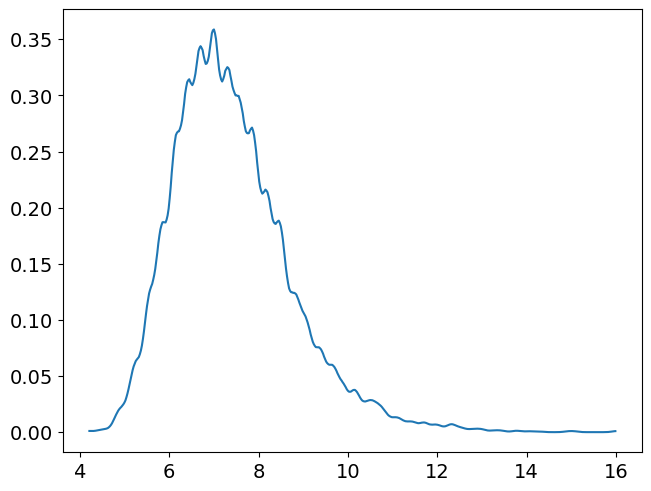

In [95]:
az.plot_kde(sample_sigma2)
plt.show()

In [2]:
# code 4.26 +
d = pd.read_csv("data/Howell1.csv", sep=";", header=0)
d2 = d[d.age>=18]

with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

<ipython-input-2-886ab6c6088a>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_1 = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


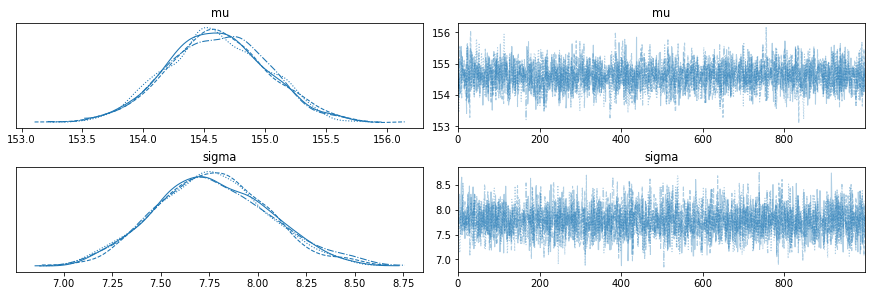

In [11]:
#pm.traceplot(trace_4_1)
with m4_1:
    az.plot_trace(trace_4_1);

In [18]:
az.summary(trace_4_1, var_names=["mu", "sigma"], round_to=2, kind="stats")

/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
mu,154.61,0.41,153.85,155.39
sigma,7.77,0.30,7.19,8.31


In [19]:
# code 4.31
d = pd.read_csv("data/Howell1.csv", sep=";", header=0)
d2 = d[d.age>=18]

with pm.Model() as m4_2:
    mu = pm.Normal("mu", mu=178, sd=0.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    
with m4_2:
    trace_4_2 = pm.sample(1000, tune=1000)

<ipython-input-19-dcf059a5e281>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_2 = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
mu,177.86,0.10,177.68,178.04
sigma,24.59,0.92,22.82,26.28


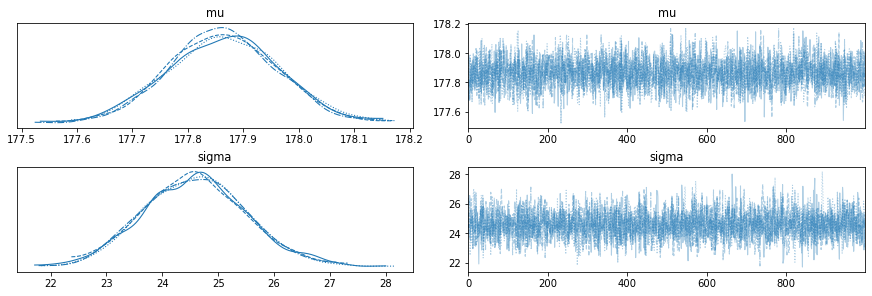

In [22]:
with m4_2:
    az.plot_trace(trace_4_2)
az.summary(trace_4_2, var_names=["mu", "sigma"], round_to=2, kind="stats")

In [26]:
# code 4.32
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

,mu,sigma
mu,0.171113,0.002128
sigma,0.002128,0.087261


In [27]:
np.diag(trace_df.cov()) # diagonal gives us the variances

array([0.17111311, 0.08726111])

In [28]:
trace_df.corr() # correlations

,mu,sigma
mu,1.000000,0.017414
sigma,0.017414,1.000000


In [29]:
# code 4.34
trace_df.head()

,mu,sigma
0,154.632446,7.961289
1,154.939041,7.662434
2,154.248764,7.972524
3,155.145355,7.716280
4,154.276016,7.818957


In [30]:
print("10 Sigma samples: ", trace_4_1["sigma"][:10])
print("10 Mu samples: ", trace_4_1["mu"][:10])

10 Sigma samples:  [7.9612894 7.6624336 7.972524  7.7162795 7.818957  7.8100777 7.510009
 8.127805  8.498109  8.646414 ]
10 Mu samples:  [154.63245 154.93904 154.24876 155.14536 154.27602 154.02788 155.05882
 154.43272 155.54045 155.09511]


In [31]:
# code 4.36
stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(), size=10)

array([[154.93206719,   7.92969857],
       [154.46246385,   8.12607054],
       [154.23462908,   7.62413874],
       [155.14613664,   7.94901643],
       [154.56240393,   7.82553119],
       [155.16514822,   7.64136103],
       [154.47120835,   7.98807138],
       [154.39184268,   7.49077795],
       [154.46257333,   7.77201244],
       [154.26808254,   7.74955319]])

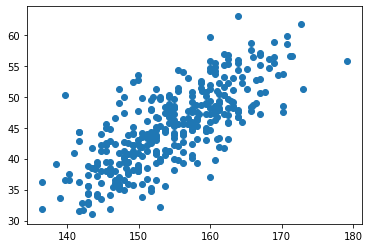

In [33]:
# code 4.37
plt.scatter(d2["height"], d2["weight"]);

In [47]:
# code 4.38
N = 100
a = np.random.normal(178, 20, size=N)
b = np.random.normal(0, 10, size=N)

[ -6.9252241  -19.29442497  -2.93085063  -2.03201576  14.20083927
  10.03913338   0.38242155  10.16158843   8.07530788   5.24738838
   1.66945168  -5.0322958    0.52845695  -6.92726123  -6.11451075
   2.31741914  -4.59303842 -16.12095175   0.86493082 -12.02790356
  -6.27533887 -10.34873346  -6.52475766   2.53850943  -9.05020147
  15.85541212  12.98407616  26.96427565  -0.92115085  12.85273175
  20.1153465  -15.60374839   3.96798171  10.63237143  -8.47092092
 -22.35055231  -0.5263859    8.15303738   4.17295652   1.30285517
  -6.85632763 -14.01509904 -20.71551164   8.71551055   6.09684567
   3.50129039 -19.04211369 -13.98254426  -4.88924784   5.37010367
  -3.35197572 -14.32042945 -14.65566714   1.57679116  11.78970081
  -7.50381299  -0.14728734   2.22474486  -5.18151302  -0.93532124
  11.44476325   3.84140511  -4.15603553  -4.31541768  -2.52849104
 -21.4972969    9.69765138 -14.93534955  -5.32114437   0.91619992
 -13.50101697  11.35967107 -10.22519197 -11.34914457  -0.25827585
   4.25294

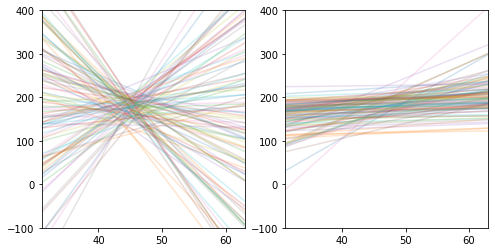

In [72]:
# code 4.39
lb = np.random.lognormal(0,1, size=N)
x = np.linspace(d2["weight"].min(), d2["weight"].max(), 1000)
xbar = d2["weight"].mean()

fig, ax = plt.subplots(1,2,figsize=(8,4))
for i in range(N):
    ax[0].plot(x, a[i] + b[i]*(x-xbar), alpha=0.2)
    ax[1].plot(x, a[i] + lb[i]*(x-xbar), alpha=0.2)
    
ax[0].set_xlim(d2["weight"].min(), d2["weight"].max())
ax[1].set_xlim(d2["weight"].min(), d2["weight"].max())
ax[0].set_ylim([-100, 400])
ax[1].set_ylim([-100, 400]);

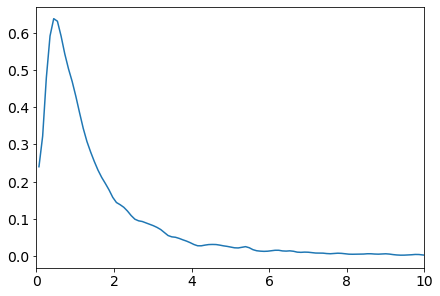

In [86]:
# code 4.40
b = np.random.lognormal(0, 1, 10000)
az.plot_kde(b)
plt.xlim([0,10])
plt.show()

In [89]:
# code 4.42
d = pd.read_csv("data/Howell1.csv", sep=";", header=0)
d2 = d[d.age>=18]
xbar = d2["weight"].mean()

with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = a + b * (d2.weight - xbar)
    height = pm.Normal("height", mu=mu, sd=sigma, observed = d2.height)
    
    trace_4_3 = pm.sample(1000, tune=1000)
    

<ipython-input-89-c411f38b7e87>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_3 = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [94]:
az.summary(trace_4_3, var_names=["a", "b", "sigma"], round_to=2, kind="stats")

/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
a,154.60,0.28,154.09,155.11
b,0.90,0.04,0.82,0.98
sigma,5.11,0.20,4.75,5.49


In [95]:
trace_df = pm.trace_to_dataframe(trace_4_3)
trace_df.cov()

,a,b,sigma
a,0.076248,-0.000113,0.001207
b,-0.000113,0.001865,-0.000128
sigma,0.001207,-0.000128,0.039431


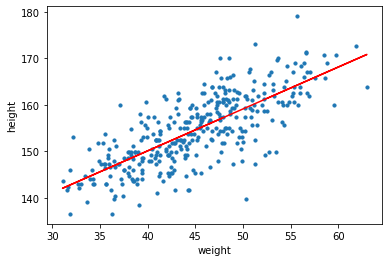

In [106]:
am = trace_4_3["a"].mean()
bm = trace_4_3["b"].mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), 1000)

plt.scatter(d2.weight, d2.height, 10)
plt.plot(d2.weight, am + bm*(d2.weight - d2.weight.mean()), 'r')
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

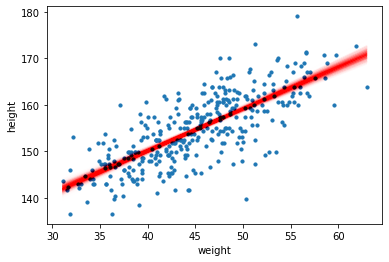

In [117]:
# code 4.49
plt.scatter(d2.weight, d2.height, 10)
for i in range(1000):
    plt.plot(d2.weight, trace_4_3["a"][i] + trace_4_3["b"][i] * (d2.weight - d2.weight.mean()), 'r', alpha=0.002)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

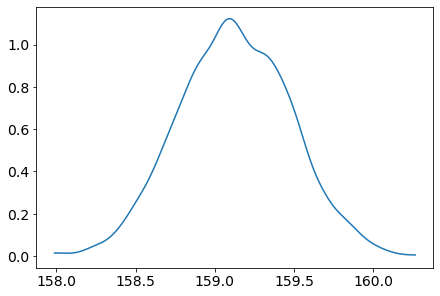

In [119]:
# code 4.50
mu_at_50 = trace_4_3["a"] + trace_4_3["b"] * (50 - xbar)
az.plot_kde(mu_at_50);

In [120]:
az.hdi(mu_at_50)

array([158.46082, 159.76514], dtype=float32)